# Link between GitHub repository and ExTRI2 paper
A notebook containing links to, or code for, generating the figures, tables, and results for the ExTRI2 paper, divided by the different sections in the paper.

Go to each section to see the analysis done, or a link to the script/notebook that contains the information.

In [23]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('repo_to_paper.ipynb')

<h3>Table of contents</h3>


[Link between GitHub repository and ExTRI2 paper](#Link-between-GitHub-repository-and-ExTRI2-paper)
- [Setup & configuration](#Setup-&-configuration)
- [0. Unorganised analysis functions](#0.-Unorganised-analysis-functions)
- [2.1. The ExTRI2 pipeline](#2.1.-The-ExTRI2-pipeline)
- [2.2. Pipeline Results](#2.2.-Pipeline-Results)
- [2.3.1. Classifiers Performance & 3.3. Classifier configuration and training](#2.3.1.-Classifiers-Performance-&-3.3.-Classifier-configuration-and-training)
  - [2.3.1.](#2.3.1.)
  - [3.3.](#3.3.)
- [2.3.2. Validation Outcomes & 3.5. Validation Criteria and Process](#2.3.2.-Validation-Outcomes-&-3.5.-Validation-Criteria-and-Process)
  - [MUST CORRECT](#MUST-CORRECT)
- [3.1. Data Sources & Preparation](#3.1.-Data-Sources-&-Preparation)
  - [3.1.1. Retrieving Annotated Abstracts - PubTator3 Dataset](#3.1.1.-Retrieving-Annotated-Abstracts---PubTator3-Dataset)
  - [3.1.2. Retrieving TF Gene IDs - TFCheckpoint and GO annotations](#3.1.2.-Retrieving-TF-Gene-IDs---TFCheckpoint-and-GO-annotations)
- [3.2. Curated Dataset for Training - The NTNU collection](#3.2.-Curated-Dataset-for-Training---The-NTNU-collection)
- [3.4. Improvement of the Training Dataset](#3.4.-Improvement-of-the-Training-Dataset)
  - [3.4.1 Sentence Splitter](#3.4.1-Sentence-Splitter)
  - [3.4.2 Iterative Classifier Training and Validation](#3.4.2-Iterative-Classifier-Training-and-Validation)

## Setup & configuration

In [3]:
# IMPORTS
import pandas as pd
import numpy as np
import os
import json
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import h3, h4, h5, md
from analysis import load_config, retrieve_annotations_entrez
pd.set_option('display.max_colwidth', 20)

In [4]:
# UNCOMMENT TO REIMPORT A CERTAIN FUNCTION AFTER MODIFYING ITS CODE
import importlib 
import analysis
importlib.reload(analysis)
from analysis import *

In [5]:
# LOAD DATA
config = load_config()

# Load ExTRI dataset
ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)
# Add columns to ExTRI2 df to facilitate analysis
ExTRI2_df['TRI Id']             = ExTRI2_df['TF Id'] + '|' + ExTRI2_df['TG Id']

# Load the validation dataset
validated_df           = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)

## 0. Unorganised analysis functions

Some general analysis of ExTRI2 not relevant for the paper

In [6]:
def show_analytics(label, num, total):
    total_len = total if type(total) is int else len(total)
    num_len = num if type(num) in (int, np.int64) else len(num)
    print(f'{label:30}{num_len:,}/{total_len:<10,}{num_len/total_len:>10.2%}')

def display_uniques():
    h3("Unique values")
    m_cols = ['#SentenceID', 'Sentence', 'PMID', 'TRI Id', 'PMID+Sent+TRI_Id', '',
            'Valid', 'MoR', 'TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes', 'Mutated_TF'] 

    total = len(ExTRI2_df)
    for col in m_cols:
        if col == '':
            print()
            continue
        num = ExTRI2_df[col].unique()
        show_analytics(f'Unique {col}', num, total)

def display_NA_values():
    h3("Columns with Na values")
    cols_to_ignore = ['Mutated Genes', 'Mutation offsets', 'tags', 'renormalisation']

    total = len(ExTRI2_df)
    for col in ExTRI2_df.columns:
        col_has_na = max(int(ExTRI2_df[col].isna().sum()), int((ExTRI2_df[col] == '').sum()))
        if col_has_na & (col not in cols_to_ignore):
            show_analytics(f'{col}', col_has_na, total)

def display_cols_with_colons():
    h3("Columns with colons (;)")
    colon_cols = ['TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes']

    total = len(ExTRI2_df)
    for col in colon_cols:
        if col == '':
            print()
            continue
        num = int(ExTRI2_df[col].str.contains(';').sum())
        show_analytics(f'{col}', num, total)


    h3("Number of unique rows with ;")
    for col in colon_cols:
        if col == '':
            print()
            continue
        if ExTRI2_df[col].isna().sum() != 0:
            continue
        m = ExTRI2_df[col].str.contains(';')
        num = ExTRI2_df[m][col].unique()
        num_un = ExTRI2_df[col].unique()
        show_analytics(f'{col}', num, num_un)

def display_TF_types():
    h3("Joined TF Types")
    squished = ExTRI2_df['TF_type'].apply(lambda x: ";".join(set(x.split(';'))))
    print(squished.value_counts())
    print()

def display_unique_content_per_col():
    h3("Columns with <30 unique values")
    for col in ExTRI2_df.columns:
        uniq = ExTRI2_df[col].unique()
        if len(uniq) < 30:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq.astype(str))}")
        else:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq[:2])}")

# TODO - Will I comment anything on mutated TFs in the paper? If not, just leave this function here. Otherwise, move to appropriate section.
def display_mutation_analysis():
    analysis = {
        'TOTAL': [],
        'UNDEFINED': [],
        'ACTIVATION': [],
        'REPRESSION': [],
        'Uniq. TRIs': [],
        'TRI maps to 1 MoR': [],
        'TRI maps to 2 MoR': [],
        'TRI maps to 3 MoR': []
    }
    mask = ExTRI2_df['Mutated_TF'] == 'True'
    TRI_mutated    = ExTRI2_df[mask]
    TRI_nonmutated = ExTRI2_df[~mask]
    for df in (ExTRI2_df, TRI_nonmutated, TRI_mutated):
        analysis['TOTAL'].append(len(df))
        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analysis[mor].append(f"{len(df[df['MoR'] == mor])} ({len(df[df['MoR'] == mor])/len(df):.2%})")
        analysis['Uniq. TRIs'].append(df['TRI Id'].nunique())

        # Analyse whether TRIs get assigned more than 1 MoR.
        grouped = df.groupby('TRI Id')['MoR'].nunique()
        analysis['TRI maps to 1 MoR'].append((grouped == 1).sum())
        analysis['TRI maps to 2 MoR'].append((grouped == 2).sum())
        analysis['TRI maps to 3 MoR'].append((grouped == 3).sum())
        
    analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=['All ExTRI2_df', 'Non-mutated', 'Mutated'])
    # display(analysis_df.style.format('{:,}'))
    h3("Comparison of sentences with and without mutated TFs")
    display(analysis_df)

display_uniques()
display_cols_with_colons()
display_TF_types()
display_unique_content_per_col()
display_mutation_analysis()

<h3>Unique values</h3>

Unique #SentenceID            836,024/836,024      100.00%
Unique Sentence               834,786/836,024       99.85%
Unique PMID                   293,108/836,024       35.06%
Unique TRI Id                 284,724/836,024       34.06%
Unique PMID+Sent+TRI_Id       836,024/836,024      100.00%

Unique Valid                  1/836,024        0.00%
Unique MoR                    3/836,024        0.00%
Unique TF_type                78/836,024        0.01%
Unique TF TaxID               20/836,024        0.00%
Unique TG TaxID               22/836,024        0.00%

Unique TF                     24,083/836,024        2.88%
Unique TF Id                  7,180/836,024        0.86%
Unique TF Symbol              6,139/836,024        0.73%
Unique TF_human_entrez_gene   4,792/836,024        0.57%
Unique TF_hgnc_id             4,789/836,024        0.57%
Unique TF_human_symbol        4,789/836,024        0.57%

Unique TG                     55,571/836,024        6.65%
Unique TG Id                  25,

<h3>Columns with colons (;)</h3>

TF_type                       16,562/836,024        1.98%
TF TaxID                      16,562/836,024        1.98%
TG TaxID                      8,131/836,024        0.97%

TF                            68/836,024        0.01%
TF Id                         16,562/836,024        1.98%
TF Symbol                     16,562/836,024        1.98%
TF_human_entrez_gene          105,310/836,024       12.60%
TF_hgnc_id                    105,257/836,024       12.59%
TF_human_symbol               105,257/836,024       12.59%

TG                            8/836,024        0.00%
TG Id                         8,131/836,024        0.97%
TG Symbol                     8,131/836,024        0.97%
TG_human_entrez_gene          87,741/836,024       10.50%
TG_hgnc_id                    87,705/836,024       10.49%
TG_human_symbol               87,705/836,024       10.49%
Mutated Genes                 1,760/836,024        0.21%


<h3>Number of unique rows with ;</h3>

TF_type                       75/78            96.15%
TF TaxID                      17/20            85.00%
TG TaxID                      19/22            86.36%

TF                            42/24,083         0.17%
TF Id                         1,200/7,180         16.71%
TF Symbol                     1,141/6,139         18.59%
TF_human_entrez_gene          1,924/4,792         40.15%
TF_hgnc_id                    1,921/4,789         40.11%
TF_human_symbol               1,921/4,789         40.11%

TG                            8/55,571         0.01%
TG Id                         1,965/25,805         7.61%
TG Symbol                     1,902/22,904         8.30%
TG_human_entrez_gene          4,636/17,525        26.45%
TG_hgnc_id                    4,631/17,521        26.43%
TG_human_symbol               4,631/17,522        26.43%
Mutated Genes                 778/2,005         38.80%


<h3>Joined TF Types</h3>

TF_type
dbTF            432325
ll_coTF         216298
coTF            184766
ll_coTF;-         1077
coTF;-             731
coTF;dbTF          390
dbTF;-             254
dbTF;coTF          157
coTF;-;dbTF         13
ll_coTF;dbTF         4
dbTF;ll_coTF         3
ll_coTF;coTF         3
coTF;ll_coTF         3
Name: count, dtype: int64



<h3>Columns with <30 unique values</h3>

#SentenceID              836024    PMID:35388756:pubtator_title_and_abstract:cb4217d25fb4d7c895812e2f96ae2628:9:CHCHD2:GNPTG:1366:1458, PMID:26808438:pubtator_title_and_abstract:42c92af80826602081a3eaf43b49d551:7:ChREBP:Mid1ip1,Txnip:919:1050
Sentence                 834786    Chip-IP results showed that [TF] might regulate potential target genes such as HDX, ACP1, RAVER2, C1orf229, RN7SL130, [TG], erythroid 2 Like 2 (NFE2L2), required for cell differentiation 1 homologue (RQCD1), solute carrier family 5 member 7 (SLA5A7), and NAcetyltransferase 8 Like (NAT8L)., Among multiple ChREBP-controlled genes, [TF] was sufficient and necessary for regulation of Eno1, Pklr, Mdh1, Me1, Pdha1, Acly, Acaca, Fasn, Elovl6, Gpd1, Cpt1a, Rgs16, [TG], and Chrebpbeta.
TF                       24083     CHCHD2, ChREBP
TG                       55571     GNPTG, Mid1ip1,Txnip
TF Id                    7180      51142, 51085
TG Id                    25805     84572, 58526;10628
TF offset                3449   

<h3>Comparison of sentences with and without mutated TFs</h3>

,All ExTRI2_df,Non-mutated,Mutated
TOTAL,836024,833269,2755
UNDEFINED,244032 (29.19%),243211 (29.19%),821 (29.80%)
ACTIVATION,416370 (49.80%),415075 (49.81%),1295 (47.01%)
REPRESSION,175622 (21.01%),174983 (21.00%),639 (23.19%)
Uniq. TRIs,284724,284134,2031
TRI maps to 1 MoR,209430,209078,1825
TRI maps to 2 MoR,58825,58688,178
TRI maps to 3 MoR,16469,16368,28


## 2.1. The ExTRI2 pipeline

Scripts used for the different parts of the pipeline:
1. **Abstracts and Entity Extraction:** See [scripts/preprocessing/README.md](../scripts/preprocessing/README.md) for a description of the different scripts used
2. **Abstract Segmentation and Candidate Sentences Creation:** [workflow.rb](../workflow.rb)
3. **Identification of TRIs and their MoR:** [workflow.rb](../workflow.rb), using classifiers trained with [classifiers_training/run_classifiers.sh](../classifiers_training/run_classifiers.sh)
4. **Post-processing and normalization:** [scripts/postprocessing/postprocessing.py](../scripts/postprocessing/postprocessing.py)

## 2.2. Pipeline Results

In [7]:
def split_in_dbTF_coTF_ll_coTF(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_ll_coTF = ExTRI2_df['TF_type'].str.contains('ll_coTF') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    ll_coTF_df = ExTRI2_df[m_ll_coTF]

    # Check if the split was done correctly
    assert len(ExTRI2_df) == len(dbTF_df) + len(coTF_df) + len(ll_coTF_df)

    return dbTF_df, coTF_df, ll_coTF_df    

dbTF_df, coTF_df, ll_coTF_df = split_in_dbTF_coTF_ll_coTF(ExTRI2_df)

In [8]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df) -> dict:

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (ll_coTF_df, 'll_coTF')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['TF is mutated'] = f"{(df['Mutated_TF'] == 'True').sum():,} ({(df['Mutated_TF'] == 'True').sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        diff_species_m = df['TF TaxID'].apply(lambda x: set(x.split(';'))) != df['TG TaxID'].apply(lambda x: set(x.split(';')))
        analytics['TF & TG from different species'] = f"{diff_species_m.sum():,} ({diff_species_m.sum() / len(df):.2%})"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))
    return 

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"


    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

    return 

table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

,Total,dbTF,coTF,ll_coTF
TRI-sentences,"836,024","433,146","185,503","217,375"
UNDEFINED,"244,032 (29.19%)","140,063 (32.34%)","55,453 (29.89%)","48,516 (22.32%)"
ACTIVATION,"416,370 (49.80%)","210,977 (48.71%)","77,724 (41.90%)","127,669 (58.73%)"
REPRESSION,"175,622 (21.01%)","82,106 (18.96%)","52,326 (28.21%)","41,190 (18.95%)"
TG is not normalized,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
TF is mutated,"2,755 (0.33%)","1,336 (0.31%)",865 (0.47%),554 (0.25%)
Unique TRIs,"284,724","143,651","83,280","57,793"
Unique TF IDs,"7,180","3,453","3,078",649
Unique human TF IDs,"2,758","1,280","1,322",156
Unique TG IDs,"25,805","20,609","14,643","13,199"


KeyboardInterrupt: 

<h3>Figure 2</h3>

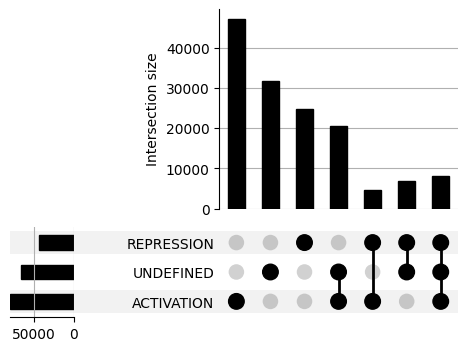

<h3>Table S6</h3>

,Counts
ACTIVATION,"47,148 (32.82%)"
REPRESSION,"24,763 (17.24%)"
UNDEFINED,"31,691 (22.06%)"
"ACTIVATION,REPRESSION","4,613 (3.21%)"
"ACTIVATION,UNDEFINED","20,593 (14.34%)"
"REPRESSION,UNDEFINED","6,735 (4.69%)"
"ACTIVATION,REPRESSION,UNDEFINED","8,108 (5.64%)"
1 MoR,"103,602 (72.12%)"
2 MoR,"31,941 (22.24%)"
3 MoR,"8,108 (5.64%)"


In [ ]:
# FIGURE 2 & TABLE S1
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S1(MoR_counts, MoR_listoflists):
    h3("Table S1")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S1(MoR_counts, MoR_listoflists)

24402 (2.92%) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID
There are 0 human TFs and 85 human TGs in ExTRI2 that are not found in the all_human_genes df.
There are 87 human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)
They appear in 427 rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,291179,429303,10185,14248,5.3%,10.7%
PROTEIN_CODING,281247,371481,9189,9902,44.6%,48.1%
ncRNA,8239,9975,815,820,3.7%,3.7%
PSEUDO,832,875,108,117,0.6%,0.7%
OTHER,739,610,38,31,4.5%,3.7%
snoRNA,22,25,11,13,0.9%,1.1%
tRNA,43,43,8,8,1.2%,1.2%
snRNA,31,31,7,7,4.2%,4.2%
BIOLOGICAL_REGION,15,0,6,0,0.0%,0.0%
rRNA,1,1,1,1,0.1%,0.1%


<span style='color:red'>There are 3 dbTFs that are non considered to be protein-coding, but are kept in the analysis.

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
8461,100859930,HEIH,ncRNA,Homo sapiens,hepatocellular c...
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1841,100.0%
retrieved directly,1280,69.5%
retrieved (including orthologs),1332,72.4%


<h3>Figure 3</h3>

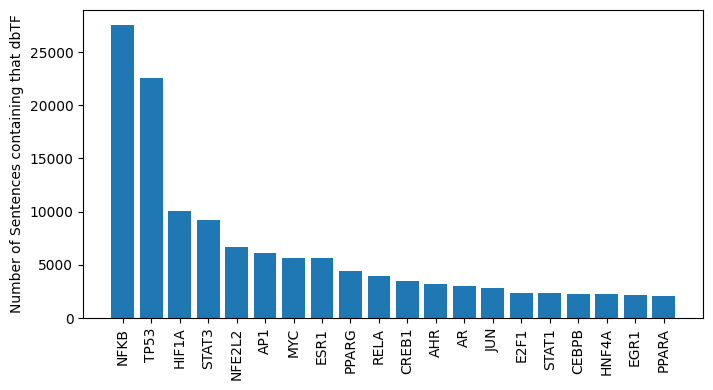

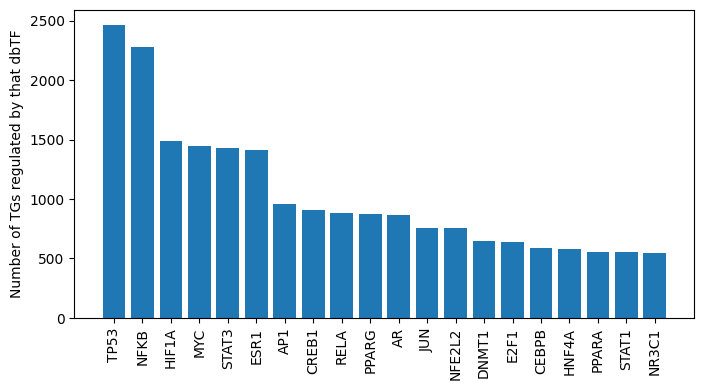

In [ ]:
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Get human TGs
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606')] 

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)")
    print(f"They appear in {(~m_TG_id).sum()} rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_entrez_gene'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_entrez_gene'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_entrez_gene'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(dbTF_df, all_human_genes):

    human_dbTF_df = dbTF_df[(dbTF_df['TF TaxID'] == '9606')] 

    # Get all retrieved human dbTFs
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])

    # Get set of human dbTFs used in ExTRI2
    with open(config['dbTFs_p'], 'r') as f:
        dbTFs_set = {l.strip('\n') for l in f}
    # Add NFKB and AP1 complexes
    dbTFs_set |= {'Complex:NFKB', 'Complex:AP1'}

    # Ensure retrieved dbTFs are in the original list of dbTFs
    assert retrieved_TF_IDs.issubset(dbTFs_set), "Some dbTFs are not part of the original dbTFs list"

    # Ensure they are all in the list of human genes
    assert retrieved_TF_IDs.issubset(set(all_human_genes['NCBI GeneID'])), "Some dbTFs are not part of the NCBI df"

    # Check if they are all protein-coding genes
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    md(f"<span style='color:red'>There are {len(non_protein_coding_dbTFs)} dbTFs that are non considered to be protein-coding, but are kept in the analysis.")
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get the set of human dbTFs
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID']))

    # Prepare the dataframe to display, with counts and percentages
    human_dbTF_summary = {
        category: {
            "unique": count,
            "%": f"{count / len(human_dbTFs_set):.1%}"
        }
        for category, count in {
            'all considered': len(human_dbTFs_set),
            'retrieved directly': len(human_dbTF_df['TF Id'].unique()),
            'retrieved (including orthologs)': len(dbTF_df[~dbTF_df['TF_human_entrez_gene'].str.contains(';')]['TF_human_entrez_gene'].unique())
        }.items()
    }

    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(human_dbTF_summary, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    # Plot dbTFs that appear in most sentences
    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    
    # Plot dbTFs that are associated with the most TGs
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    

def human_TF_TG_analysis(ExTRI2_df):
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2%}) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    m_TF_id = human_dbTF_df['TF Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TF = human_dbTF_df[~m_TF_id]['TF Id'].unique()

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TG = human_dbTF_df[~m_TG_id]['TG Id'].unique()

    print(f"There are {len(not_found_human_TF)} human TFs and {len(not_found_human_TG)} human TGs in ExTRI2 that are not found in the all_human_genes df.")

    # Show how many TGs and TFs we've obtained
    display_TG_distribution(dbTF_df, all_human_genes)
    display_TF_distribution(dbTF_df, all_human_genes)

    # Plot counts
    figure_3(human_dbTF_df)

    return

human_TF_TG_analysis(ExTRI2_df)

## 2.3.1. Classifiers Performance & 3.3. Classifier configuration and training

### 2.3.1.
Final models F1 score on test dataset: 0.94 for TRI and 0.95 for MoR. Obtained from [classifiers_comparison.ipynb/Final models](classifiers_comparison.ipynb)

### 3.3.
Facts stated in the text
* Train-test split is 85:15 - [src/dataset.py](../classifiers_training/src/dataset.py)
* **Table S3:** Values obtained from [classifiers_comparison.ipynb/Final iteration](classifiers_comparison.ipynb)
* **Table S2 and Table S4:** Values obtained from [classifiers_comparison.ipynb/Previous iterations](classifiers_comparison.ipynb)

## 2.3.2. Validation Outcomes & 3.5. Validation Criteria and Process

In [14]:
# Save validated_df in the format specified in the paper
def save_paper_validated_df(validated_df):
    '''Get the validated_df in the format specified in the paper'''

    # Only keep relevant columns
    columns = ['#SentenceID', 'Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'true_MoR', 'Valid score', 'MoR scores',  # TRI - MoR validation
               'TF', 'TF Id', 'TF Symbol', 'TF TaxID',  'TF_is_incorrect', 'TF_correct_mention', 'TF offset',               # TF validation
               'TG',  'TG Id', 'TG Symbol', 'TG TaxID', 'TG_is_incorrect', 'TG_correct_mention', 'Gene offset',             # TG validaiton
               'TF_type_validated', 'method', 'stage', 'renormalisation', 'pre-post', 'TF_type',                            # Metadata
               'Other issues', 'Explanation', 
               'Mutated Genes', 'Mutation offsets', 'Mutated_TF'
               ]
    
    # Only keep relevant columns
    paper_val_df = validated_df[columns].copy()

    # Change column names to match with paper
    paper_val_df.rename(columns={'Label': 'TRI', 'true_label': 'true_TRI', 'Valid score': 'TRI score'}, inplace=True)

    # Change TRI labels to match with paper
    paper_val_df['TRI'] = paper_val_df['TRI'].replace({'FALSE': 'Not TRI', 'TRUE': 'TRI'})
    paper_val_df['true_TRI'] = paper_val_df['true_TRI'].replace({'FALSE': 'Not TRI', 'TRUE': 'TRI'})    

    # TODO - If I remove sentences from the ExTRI2 dataset (Those where TF/TG have multiple mappings or 
    # map to different species, I must remove those sentences from here too and redo the validation results)
    
    # Save into "tables/" folder
    pd.DataFrame.to_csv(paper_val_df, "tables/all_validated_sentences.tsv", sep='\t', index=False, header=True)

    display(paper_val_df.head())
    
    return

save_paper_validated_df(validated_df)

,#SentenceID,Sentence,TRI,MoR,Valid?,true_TRI,true_MoR,TRI score,MoR scores,TF,...,method,stage,renormalisation,pre-post,TF_type,Other issues,Explanation,Mutated Genes,Mutation offsets,Mutated_TF
0,10490613:2:NF-ka...,A hallmark of in...,TRI,ACTIVATION,F,Not TRI,NaN,0.8904183511032965,0.00833613522600...,NF-kappaB.,...,random,s1,NFKB,pre,dbTF,Splitter,NaN,NaN,NaN,False
1,34564314:2:TP53:...,Long non-coding ...,TRI,UNDEFINED,T,TRI,UNDEFINED,0.9914710518979726,0.99718615402933...,TP53,...,random,s1,NaN,pre,dbTF,NaN,NaN,NaN,NaN,False
2,33916908:6:NRF2:EGF,ChIP sequencing ...,TRI,UNDEFINED,T,TRI,UNDEFINED,0.9912978508624892,0.99766902869249...,NRF2,...,random,s1,NaN,pre,dbTF,NaN,NaN,NaN,NaN,False
3,33766982:4:Camta...,"In this study, w...",TRI,UNDEFINED,F,Not TRI,NaN,0.9510048579935686,0.99678953469570...,Camta1,...,random,s1,NaN,pre,dbTF,NaN,NaN,NaN,NaN,False
4,32972752:0:SETDB...,Knockout of [TF]...,TRI,REPRESSION,F,TRI,UNDEFINED,0.990418271106595,0.01346601239389...,SETDB1,...,random,s1,NaN,pre,dbTF,mutation,NaN,NaN,NaN,False


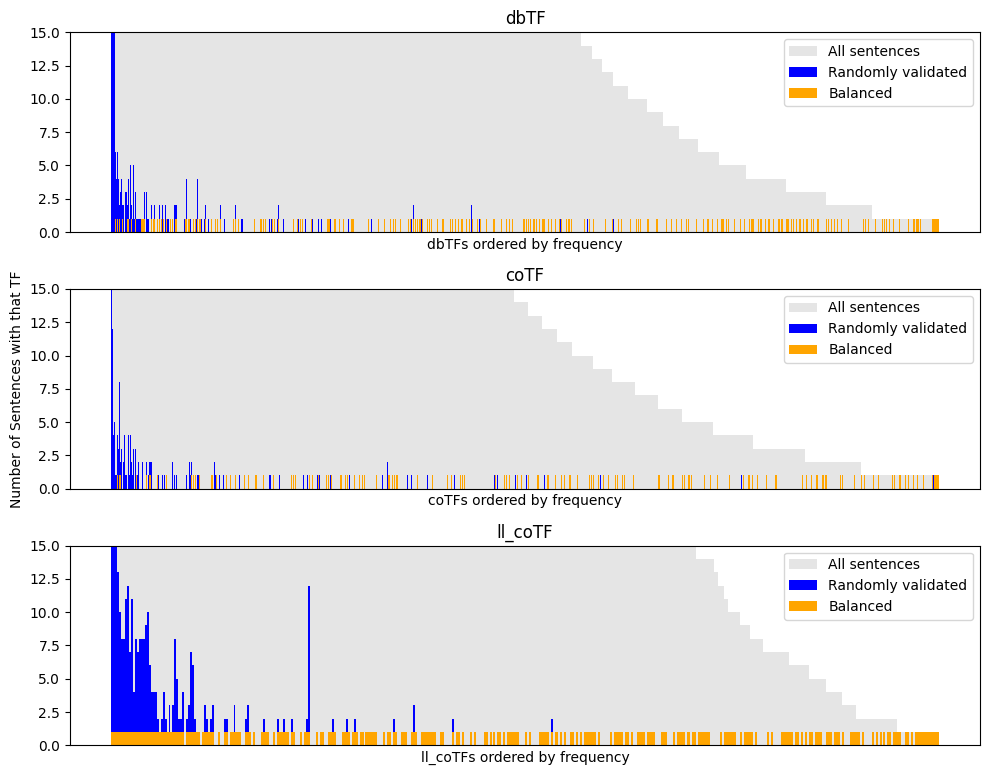

In [ ]:
# PLOT - Ensure correctly balanced validation dataset
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Randomly validated", "blue", 1),
        (val_balanced, 'Balanced', "orange", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(['dbTF', 'coTF', 'll_coTF']):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type_validated'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)
    axes[1].set_ylabel(f"Number of Sentences with that TF")



    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

title = "Distribution of the TFs for the random and balanced datasets for the three TF types"
plot_all_tf_validation_distributions('', ExTRI2_df, validated_df[(validated_df['pre-post'] == 'pre') & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 15)

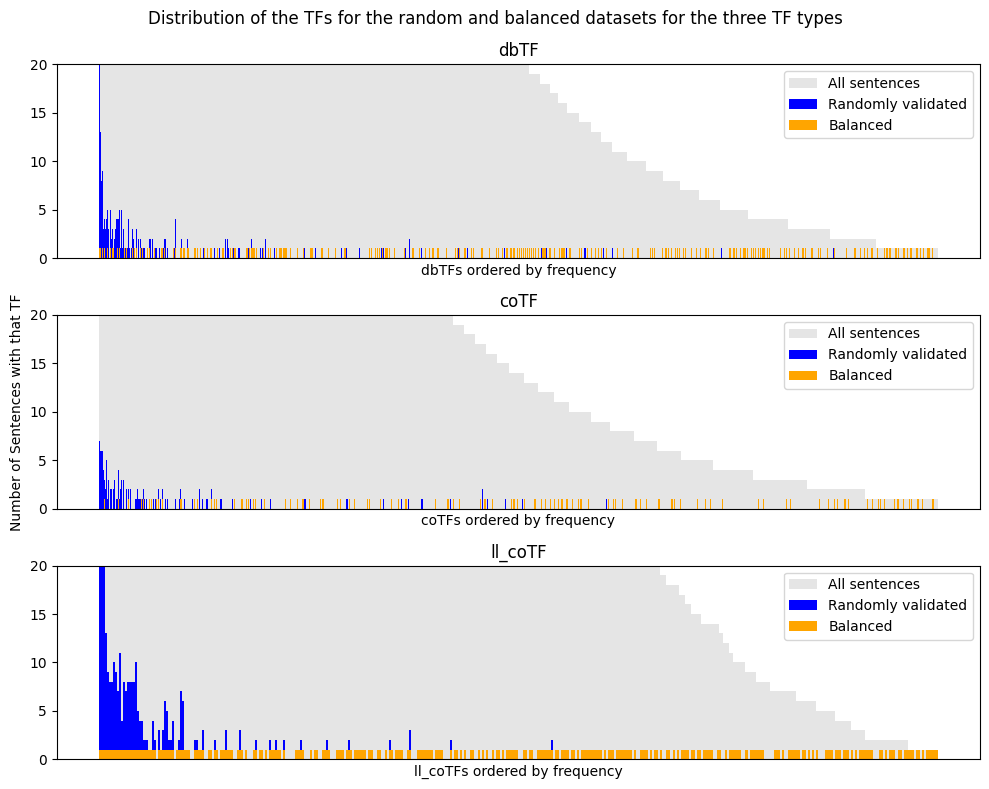

In [ ]:
plot_all_tf_validation_distributions(title, ExTRI2_df, validated_df[(validated_df['pre-post'] == 'post') & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 20)

In [ ]:
def evaluate_other_issues(validated_df):
    h3("Other issues")

    # Get sentences where there are other issues
    o_i = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first').dropna(subset=['Other issues'])

    # Display common issues
    display(o_i['Other issues'].apply(lambda x: x.split(';')).explode().value_counts())

    # Get uniquely validated sentences
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    # Splitter / suboptimal / dir-gene issues
    m = validated_unique['Other issues'].fillna('').str.contains('Splitter')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are incorrecty splitted")
    m = validated_unique['Other issues'].fillna('').str.contains('suboptimal')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are suboptimal")
    m = validated_unique['dir-*'].fillna('') == 'dir-gene'
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences classified as 'dir-gene")

    # Check for more common issues, what proportion of the dataset do they appear in
    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                for validity in ['T', 'F']:

                    df = validated_df[(validated_df['TF_type_validated'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p) & (validated_df['Label'] == 'TRUE') & (validated_df['Valid?'] == validity)]
                    
                    r = {
                        'tf_type': tf_type,
                        'Valid?': validity,
                        'method': method,
                        'pre-post': p,
                        'num_sents': str(len(df))
                    }

                    for issue in ['mutation', 'PPI', 'negation']:
                        m = df['Other issues'].fillna('').str.contains(issue)
                        r[issue] = len(df[m]) / len(df) if m.sum() > 0 else 0
            
                    results.append(r)
    
    index_cols = ['tf_type', 'Valid?', 'method', 'pre-post']
    return pd.DataFrame(results).sort_values(by=index_cols).set_index(index_cols)
  
def display_o_i_joined_pre_post(o_i_results):

    index = ['tf_type', 'Valid?', 'method']
    # Pivot pre-post from row index to column index
    o_i_pivot = o_i_results.reset_index().pivot_table(
        index=index,
        columns='pre-post',
        values=['num_sents', 'mutation', 'PPI', 'negation'],
        aggfunc= lambda x: x#f"{x:.2%}" if isinstance(x, float) else str(x)
    )

    # Convert all values to strings for easier handling
    for col in ['mutation', 'PPI', 'negation']:
        o_i_pivot[col] = o_i_pivot[col].map(lambda x: f"{x:.1%}" if isinstance(x, (float)) else str(x))

    # Combine pre and post columns for each metric
    for col in ['mutation', 'PPI', 'negation', 'num_sents']:
        o_i_pivot[(col, 'pre-post')] = (
            o_i_pivot[(col, 'pre')].astype(str) + ' - ' + o_i_pivot[(col, 'post')].astype(str)
        )

    # Filter unnecessary columns
    o_i_pivot = o_i_pivot.filter(like='pre-post')

    # Drop pre-post level
    o_i_pivot.columns = o_i_pivot.columns.droplevel(level=1)

    # Sort tf_type in the order: dbTF, coTF, ll_coTF
    o_i_pivot = o_i_pivot.reset_index()
    o_i_pivot['tf_type'] = pd.Categorical(
        o_i_pivot['tf_type'], categories=['dbTF', 'coTF', 'll_coTF'], ordered=True
    )
    o_i_pivot = o_i_pivot.sort_values(by=index).set_index(index)


    h3('Other issues, pre-post')
    display(o_i_pivot)

o_i_results = evaluate_other_issues(validated_df)
display_o_i_joined_pre_post(o_i_results)

<h3>Other issues</h3>

Other issues
mutation      800
PPI           370
Splitter       50
negation       38
suboptimal      6
Name: count, dtype: int64

50/3990 (1.3%) sentences are incorrecty splitted
6/3990 (0.2%) sentences are suboptimal
2/3990 (0.1%) sentences classified as 'dir-gene


<h3>Other issues, pre-post</h3>

mutation            PPI     negation  num_sents
tf_type Valid? method                                                        
dbTF    F      balanced    5.3% - 5.8%  22.4% - 26.7%  0.6% - 0.8%  170 - 120
               random    18.3% - 18.8%    6.3% - 5.5%  2.1% - 2.3%  142 - 128
        T      balanced  24.6% - 20.6%    0.0% - 0.0%  1.1% - 1.4%  699 - 739
               random    31.2% - 31.1%    0.0% - 0.0%  1.6% - 1.6%  764 - 759
coTF    F      balanced    2.9% - 3.7%  50.9% - 62.1%  0.0% - 0.6%  175 - 161
               random      5.1% - 6.3%  52.8% - 62.9%  0.5% - 0.6%  195 - 159
        T      balanced  43.5% - 41.4%    0.0% - 0.0%  0.7% - 1.1%  269 - 268
               random    46.0% - 45.9%    0.0% - 0.0%  0.6% - 0.7%  313 - 303
ll_coTF F      balanced    0.8% - 0.8%  39.2% - 47.1%  0.0% - 0.8%  120 - 121
               random      1.5% - 1.8%  37.4% - 44.2%  0.0% - 0.0%  198 - 163
        T      balanced  30.7% - 27.4%    0.0% - 0.0%  1.3% - 1.2%  150 - 164
               random    32.1% - 31.8%    0.0% - 0.0%  2.1% - 2.1%  237 - 233

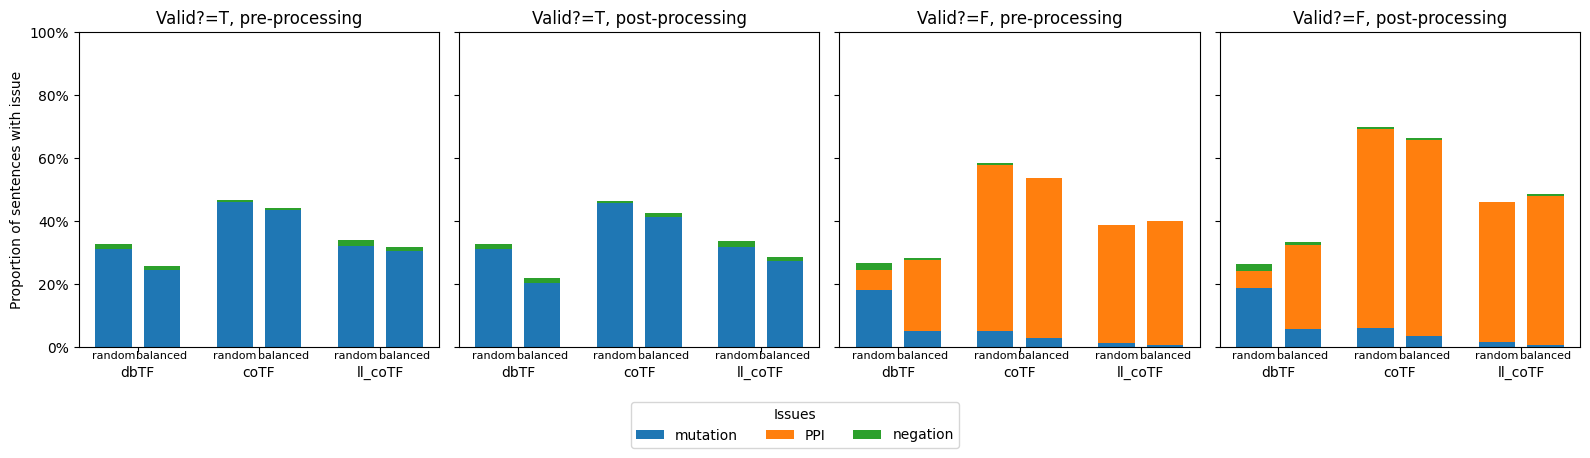

In [ ]:
def plot_other_issues_by_combination(o_i_results, figsize=(14, 4)):
    # Reset the index to use the index columns as regular columns
    o_i_results_reset = o_i_results.reset_index()

    # Define issues and tf_types
    issues = ['mutation', 'PPI', 'negation']
    tf_types = ['dbTF', 'coTF', 'll_coTF']
    hue = 'method'  # Random/Balanced will be the hue
    hue_levels = ['random', 'balanced']  # Ensure this order
    bar_width = 0.2
    group_width = bar_width * len(hue_levels) + 0.1
    withingroup_space = 0.05

    # Define combinations of Valid? and pre-post
    combinations = [
        {'Valid?': 'T', 'pre-post': 'pre'},
        {'Valid?': 'T', 'pre-post': 'post'},
        {'Valid?': 'F', 'pre-post': 'pre'},
        {'Valid?': 'F', 'pre-post': 'post'},
    ]

    # Create a plot for each combination
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    # axes = axes.flatten()

    for i, (ax, combination) in enumerate(zip(axes, combinations)):
        # Filter data for the current combination
        filtered = o_i_results_reset[
            (o_i_results_reset['Valid?'] == combination['Valid?']) &
            (o_i_results_reset['pre-post'] == combination['pre-post'])
        ]

        # Group data by tf_type and method
        grouped = filtered.groupby(['tf_type', hue])[issues].mean().reset_index()

        # Ensure tf_types and hue levels are consistent
        grouped['tf_type'] = pd.Categorical(grouped['tf_type'], categories=tf_types, ordered=True)
        grouped[hue] = pd.Categorical(grouped[hue], categories=hue_levels, ordered=True)
        grouped = grouped.sort_values(['tf_type', hue])

        # Set bar positions
        x = np.arange(len(tf_types)) * group_width

        # Plot stacked bars for each hue level
        for j, level in enumerate(hue_levels):
            level_data = grouped[grouped[hue] == level]

            # Initialize bottom values
            bottom = np.zeros(len(tf_types))

            # Plot each issue as a stacked segment
            for k, issue in enumerate(issues):
                ax.bar(
                    x + j * bar_width,  # Offset bars within the group
                    level_data[issue],
                    width=bar_width - withingroup_space,
                    bottom=bottom,
                    label=issue if j == 0 else "",
                    color=f'C{k}'
                )
                bottom += level_data[issue]

        # Add TF type labels below the bars
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)
        ax.set_xticklabels(['' for _ in tf_types])  # Temporarily blank x-ticks

        # ax.set_xticklabels(tf_types)
        ax.set_title(f"Valid?={combination['Valid?']}, {combination['pre-post']}-processing")

        # # Add individual hue labels below each bar and move TF type labels further down
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)  # Center the group


        # Add individual bar labels for the method
        for j, level in enumerate(hue_levels):
            for idx, tf_type in enumerate(tf_types):
                ax.text(
                    x[idx] + j * bar_width,  # Position based on the bar
                    -0.01,  # Move further down
                    f"{level}", ha="center", va="top", fontsize=8, rotation=0
                )

        # Add TF type labels below the hue labels
        for idx, tf_type in enumerate(tf_types):
            ax.text(
                x[idx] + (bar_width * (len(hue_levels) - 1) / 2),  # Center the label below the group
                -0.06,  # Move further down
                f"{tf_type}", ha="center", va="top", fontsize=10,
            )

        # Format the axes
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

        if i == 0:
            ax.set_ylabel('Proportion of sentences with issue')

    # Add a single legend
    fig.legend(
        labels=issues, loc='lower center', ncol=len(issues), title="Issues",
        bbox_to_anchor=(0.5, -0.15), fontsize=10
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_other_issues_by_combination(o_i_results)

In [ ]:
# TODO - Show Astrid plot & ask about 'unexpected' observations
# TODO - Move those observations elsewhere

**Observations:**<br>
Expected:
* PPI is only observed in invalid sentences
* PPI is way more common in coTF than in dbTF → coTF tends to form PPIs more frequently

Unexplained:
* PPI is way more common in balanced than random dataset → PPIs for more uncommon TFs are not detected (results dependant on the TF frequency ??)
* Negation is too uncommon to say anything relevant about it

Unexpected:
* PPI occurs more on coTF than on ll-coTF → would expect the opposite
* Mutation is way more common in random than balanced datasets → less checked for in balanced? Less detected (and thus false?)

In [ ]:
# RESULTS
def TRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    validated_df_true = validated_df[validated_df['Label'] == 'TRUE']

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df_true[(validated_df_true['TF_type_validated'] == tf_type) & (validated_df_true['method'] == method) & (validated_df_true['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'validation stage': p,
                    'num_sents': len(df)
                }

                # Get number of sentences with correct TRIs
                m_T_TRI_df = df['true_label'] == 'TRUE'
                r['Num correct TRIs'] = m_T_TRI_df.sum()

                # Get NER & norm stats
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('NER')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('NER')).sum() / r['num_sents']
                r['NER-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('NER')).sum() / r['num_sents']

                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('norm')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['norm-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('norm')).sum() / r['num_sents']
                r['norm-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('norm')).sum() / r['num_sents']

                # Get TRI stats
                r['TRI'] = 1 - (df['Label'] != df['true_label']).sum() / r['num_sents']

                # Get MoR stats - over those whose true_label is True
                # TODO - I should show the num_TRIs somewhere, & explain how the calculation was done. Maybe show num_TRIs?
                MoR_df = df[m_T_TRI_df]
                r['MoR'] = len(MoR_df[(MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df)
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['MoR'] == MoR)])

                # num_TRIs = (df['true_label'] == 'TRUE').sum()
                # r['MoR'] = 1 - len(df[(df['MoR'] != df['true_MoR']) & ~df['MoR'].isna()]) / num_TRIs
                # for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                #     r[MoR] = 1 - len(df[(df['MoR'] == MoR) & (df['MoR'] != df['true_MoR'])]) / num_TRIs


                # Get final probability                
                r['Overall']  = ((df['Valid?'] == 'T') & df[f'TF_is_incorrect'].isna() & df[f'TG_is_incorrect'].isna() ).sum() / r['num_sents']

                # Ensure num_sents is not treated as a float in the printed table
                r['num_sents'] = str(r['num_sents'])
                r['Num correct TRIs'] = str(r['Num correct TRIs'])

                results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type', 'method', 'validation stage']).T

def nonTRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include random, post-processed results'''

    validated_df = validated_df[(validated_df['method'] == 'random') & (validated_df['pre-post'] == 'post')]

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        df = validated_df[(validated_df['TF_type_validated'] == tf_type)]
        
        r = {'tf_type': tf_type}

        for label, state in (['TRUE', 'TRI'], ['FALSE', 'not TRI']):
            total_num = len(df[df['Label'] == label])
            num_valid = len(df[(df['Label'] == label) & (df['Label'] == df['true_label'])])

            r[state] = f"{num_valid}/{total_num} ({num_valid / total_num:.2%})"

        results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type']).T

def show_general_statistics(validated_df):
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    r = {}
    r['Total'] = {
        "Num validated sentences": len(validated_unique),
        "Num TRI validated sentences": len(validated_unique[validated_unique['Label'] == 'TRUE']),
        "Num Not TRI validated sentences": len(validated_unique[validated_unique['Label'] == 'FALSE']),
    }

    for TF in ['dbTF', 'coTF', 'll_coTF']:
        r[TF] = {
            "Num validated sentences": len(validated_unique[validated_unique['TF_type_validated'] == TF]),
            "Num TRI validated sentences": len(validated_unique[(validated_unique['TF_type_validated'] == TF) & (validated_unique['Label'] == 'TRUE')]),
            "Num Not TRI validated sentences": len(validated_unique[(validated_unique['TF_type_validated'] == TF) & (validated_unique['Label'] == 'FALSE')]),
        }

    display(pd.DataFrame(r))

    return

show_general_statistics(validated_df)

pd.set_option("display.float_format", "{:.1%}".format)

for results_table_f in (TRI_validation_results_table, nonTRI_validation_results_table):
    results_table = results_table_f(validated_df)
    h3(results_table_f.__name__)
    display(results_table)
    results_table.to_csv(f'tables/{results_table_f.__name__}.tsv', sep='\t')

,Total,dbTF,coTF,ll_coTF
Num validated sentences,3990,2079,1170,741
Num TRI validated sentences,3432,1788,1001,643
Num Not TRI validated sentences,558,291,169,98


<h3>TRI_validation_results_table</h3>

tf_type            dbTF                        coTF                       \
method           random       balanced       random       balanced         
validation stage    pre  post      pre  post    pre  post      pre  post   
num_sents           906   887      869   859    508   462      444   429   
Num correct TRIs    840   832      728   768    325   315      279   278   
NER               98.3% 98.6%    97.7% 98.7%  97.8% 98.1%    97.5% 97.4%   
NER-TF            99.1% 99.4%    97.9% 99.2%  98.0% 98.3%    97.7% 97.9%   
NER-TG            99.2% 99.2%    99.8% 99.5%  99.8% 99.8%    99.8% 99.5%   
norm              95.0% 96.1%    94.7% 95.8%  96.3% 97.0%    95.3% 95.8%   
norm-TF           98.8% 99.0%    96.5% 97.6%  98.0% 98.3%    96.4% 96.5%   
norm-TG           96.2% 97.1%    98.2% 98.3%  98.2% 98.7%    98.9% 99.3%   
TRI               92.7% 93.8%    83.8% 89.4%  64.0% 68.2%    62.8% 64.8%   
MoR               91.0% 91.2%    96.0% 96.2%  96.3% 96.2%    96.4% 96.4%   
Activation        92.4% 92.6%    97.3% 97.8%  96.6% 96.5%    94.7% 94.4%   
Repression        83.8% 84.6%    91.7% 90.7%  94.2% 94.0%    98.6% 97.4%   
Undefined         94.0% 94.0%    97.9% 98.8%  98.6% 98.6%    97.3% 98.7%   
Overall           79.7% 81.8%    77.2% 83.4%  59.6% 64.1%    59.0% 61.8%   

tf_type          ll_coTF                         
method            random        balanced         
validation stage     pre   post      pre   post  
num_sents            435    396      270    285  
Num correct TRIs     245    241      153    169  
NER                97.7%  99.7%    98.5%  97.9%  
NER-TF             97.7%  99.7%    98.9%  98.6%  
NER-TG            100.0% 100.0%    99.6%  99.3%  
norm               96.3%  98.7%    94.8%  95.4%  
norm-TF            96.8%  99.2%    96.7%  96.8%  
norm-TG            99.5%  99.5%    98.1%  98.6%  
TRI                56.3%  60.9%    56.7%  59.3%  
MoR                96.7%  96.7%    98.0%  97.0%  
Activation         97.0%  97.0%    98.9%  99.0%  
Repression         94.4%  94.4%    94.3%  91.1%  
Undefined         100.0% 100.0%   100.0% 100.0%  
Overall            53.6%  58.3%    53.7%  55.4%

<h3>nonTRI_validation_results_table</h3>

tf_type,dbTF,coTF,ll_coTF
TRI,832/887 (93.80%),315/462 (68.18%),241/396 (60.86%)
not TRI,289/291 (99.31%),169/169 (100.00%),98/98 (100.00%)


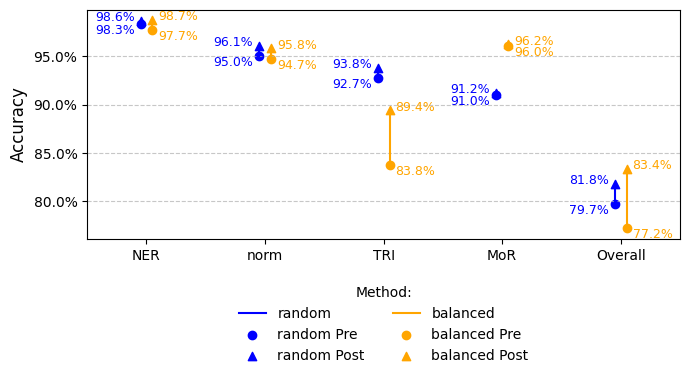

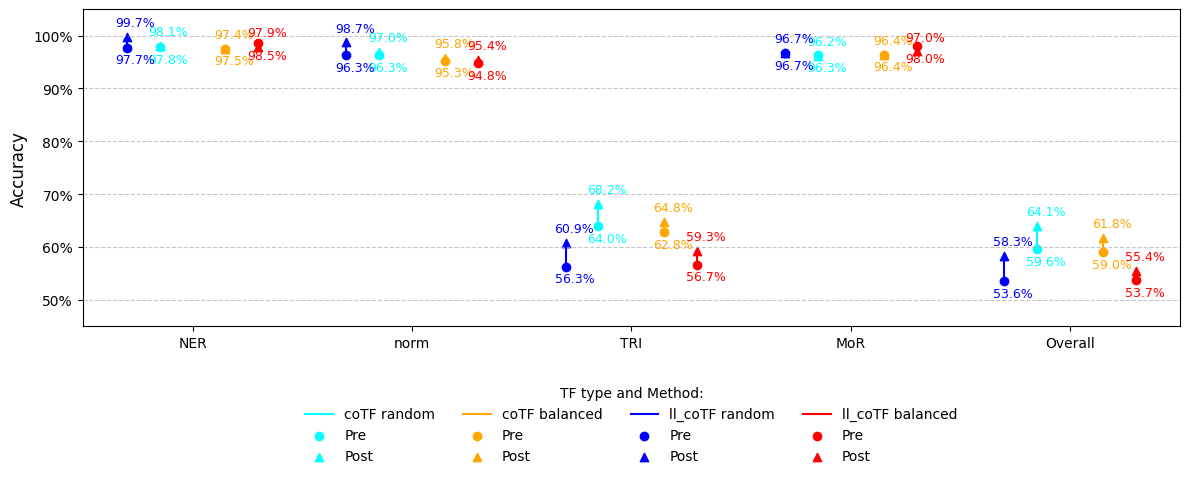

In [ ]:
def make_validation_dotplot(results_table, TF_type = 'dbTF', y_sep = 0):

    XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(7, 4))

    cols = ['NER', 'norm', 'TRI', 'MoR', 'Overall']
    for i, col in enumerate(cols):

        # Add vertical lines for random and balanced
        for method, sep, color, orientation in [('random', -0.05, 'blue', 'right'), ('balanced', 0.05, 'orange', 'left')]: 

            # Get values for random and balanced for pre and post
            values = {}
            for pre_post in ['pre', 'post']:
                values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

            ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=method if i == 0 else "")
            ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'{method} Pre' if i == 0 else "")
            ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'{method} Post' if i == 0 else "")

            # Add value labels next to the dots
            ax.text(i + sep*2, values['pre']-0.01-y_sep, f"{values['pre']:.1%}", fontsize=9, color=color, ha=orientation)
            ax.text(i + sep*2, values['post']+y_sep, f"{values['post']:.1%}", fontsize=9, color=color, ha=orientation)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    # ax.set_ylim(0.7, 1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def make_coTF_validation_dotplot(results_table, y_sep = 0.03):

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(12, 5))

    cols = ['NER','norm',  'TRI', 'MoR', 'Overall']

    for TF_type, x_sep in [('coTF', 0.15), ('ll_coTF', 0.3)]:

        XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

        for i, col in enumerate(cols):

            # Add vertical lines for random and balanced
            for method, sep, orientation in [('random', -x_sep, 'right'), ('balanced', x_sep, 'left')]: 

                if TF_type == 'coTF':
                    color = 'aqua' if method == 'random' else 'orange'
                else:
                    color = 'blue' if method == 'random' else 'red'

                # Get values for random and balanced for pre and post
                values = {}
                for pre_post in ['pre', 'post']:
                    values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

                ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=f"{TF_type} {method}" if i == 0 else "")
                ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'Pre' if i == 0 else "")
                ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'Post' if i == 0 else "")

                # Add value labels next to the dots
                ax.text(i + sep-0.05, values['pre']  - y_sep, f"{values['pre']:.1%}", fontsize=9, color=color)
                ax.text(i + sep-0.05, values['post'] + y_sep-0.01, f"{values['post']:.1%}", fontsize=9, color=color)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='TF type and Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


TRI_results_table = TRI_validation_results_table(validated_df).T.reset_index()
make_validation_dotplot(TRI_results_table)
make_coTF_validation_dotplot(TRI_results_table)

# make_validation_dotplot(results_table, 'coTF', y_sep=0.01)
# make_validation_dotplot(results_table, 'll_coTF', y_sep=0.01)

COMMENT:
* MoR remains largely unaffected by whether it is pre, post, random or not random. It is constant.
* TRI, however, is more affected. Specially for dbTF, we see a drop of 10% in the accuracy of the model when calculating balanced datasets. A trend that is not observable in coTF. This shows that our model has been trained to somewhat learn the most popular TFs
* However, for coTF it doesn't change much, as it hasn't been trained on coTFs, proving even more that it has learned about the dbTFs to consider as positives. The model is therefore better at recalling more popular TFs than those that it hasn't seen on the training set.
* For the balanced, there is a big leap between pre- and post-, which I should try to find a way to understand
* NER and norm do not see much change between conditions: they're good independently of the frequency

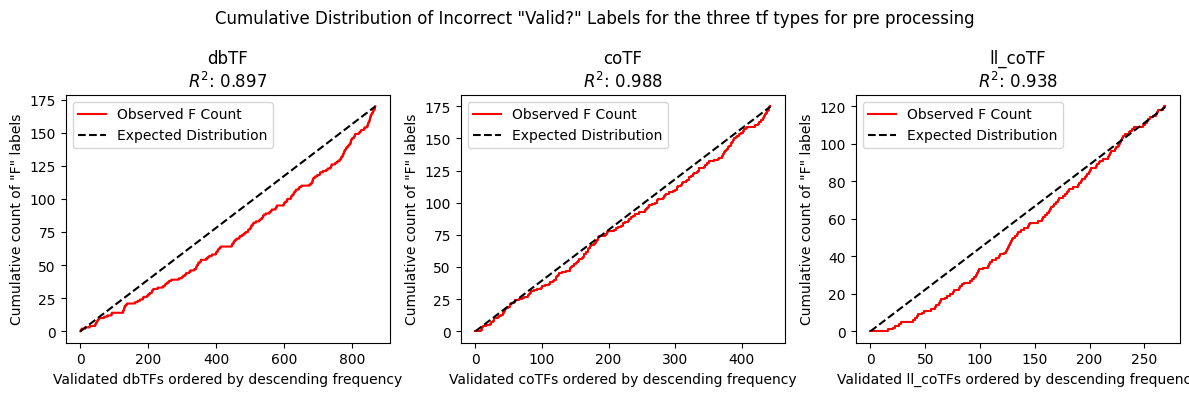

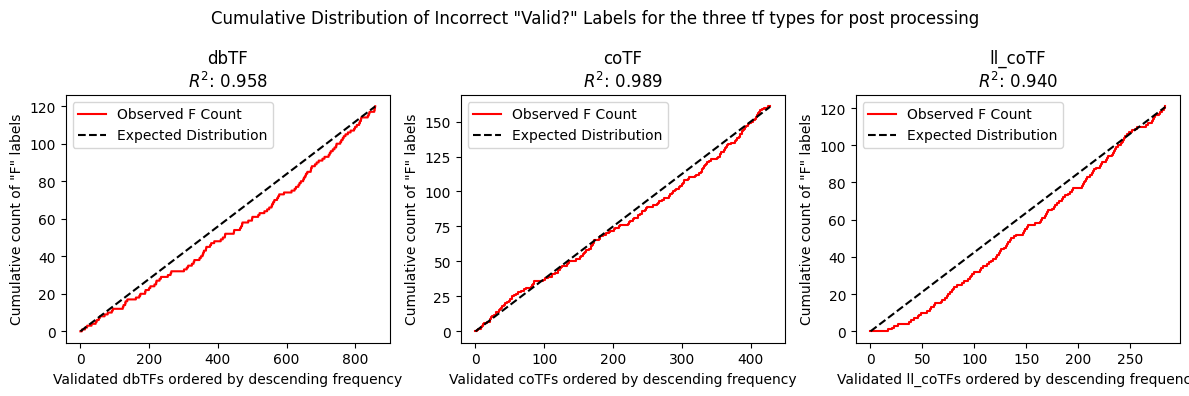

In [ ]:
from sklearn.metrics import r2_score

def plot_false_validation_distribution(ExTRI2_df: pd.DataFrame, val_df: pd.DataFrame, pre_post: str):

    # Initialise plot
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    plt.suptitle(f'Cumulative Distribution of Incorrect "Valid?" Labels for the three tf types for {pre_post} processing')


    for i, tf_type in enumerate(['dbTF', 'coTF', 'll_coTF']):

        # Get the subset of all sentences
        all_sents = ExTRI2_df[ExTRI2_df['TF_type'] == tf_type]

        # Get the subset of balanced TF_type sentences (post-processing)
        val_balanced = val_df[(val_df['TF_type'] == tf_type) & (val_df['method'] == 'balanced') & (val_df['pre-post'] == pre_post)].copy()

        # Count frequency of TF Ids in all_sents
        tf_frequencies = all_sents['TF Id'].value_counts()

        # Order the val_balanced dataset by TF frequency
        val_balanced['TF_frequency'] = val_balanced['TF Id'].map(tf_frequencies)
        val_balanced = val_balanced.sort_values(by='TF_frequency', ascending=False)

        # Add a column for the 'F' binary values (1 if Valid?=F, otherwise 0)
        val_balanced['Is_F'] = (val_balanced['Valid?'] == 'F').astype(int)

        # Compute cumulative sum of 'Is_F' for plotting
        val_balanced['Cumulative_F'] = val_balanced['Is_F'].cumsum()

        # Step 5: Plot the cumulative sum of 'F's
        ax = axes[i]
        ax.step(range(len(val_balanced)), val_balanced['Cumulative_F'], where='mid', label='Observed F Count', color='red')
        

        # Step 6: Plot the expected line
        total_f_count = val_balanced['Is_F'].sum()
        val_balanced['Expected_F'] = [total_f_count * (i / len(val_balanced)) for i in range(len(val_balanced))]
        ax.plot(range(len(val_balanced)), val_balanced['Expected_F'], label='Expected Distribution', linestyle='--', color='black')

        # Calculate R^2
        r2 = r2_score(val_balanced['Expected_F'], val_balanced['Cumulative_F'])

        # Customize plot
        ax.set_title(f"{tf_type}\n$R^2$: {r2:.3f}")
        ax.set_xlabel(f'Validated {tf_type}s ordered by descending frequency')
        ax.set_ylabel('Cumulative count of "F" labels')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_false_validation_distribution(ExTRI2_df, validated_df, 'pre')
plot_false_validation_distribution(ExTRI2_df, validated_df, 'post')

What is seen here is that unvalid sentences are more concentrated towards the end, but not by much. However, this is observed in dbTF, coTF and ll_coTF, while we might have expected dbTF to be the one that shows it more pronunciately

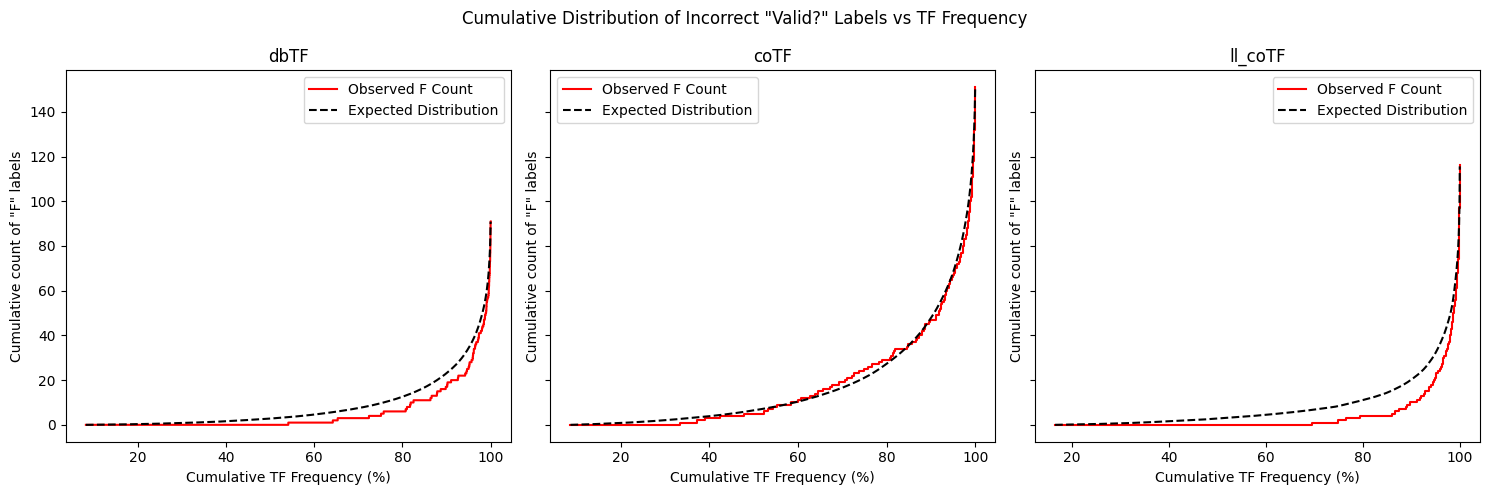

In [ ]:
def plot_notTRI_validation_distribution_frequency(ExTRI2_df: pd.DataFrame, val_df: pd.DataFrame):
    # Initialise plot
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
    plt.suptitle('Cumulative Distribution of Incorrect "Valid?" Labels vs TF Frequency')

    for i, tf_type in enumerate(['dbTF', 'coTF', 'll_coTF']):
        # Get the subset of all sentences
        all_sents = ExTRI2_df[ExTRI2_df['TF_type'] == tf_type]

        # Get the subset of balanced TF_type sentences (post-processing)
        val_balanced = val_df[(val_df['TF_type'] == tf_type) & (val_df['method'] == 'balanced') & (val_df['pre-post'] == 'post')].copy()

        # Count frequency of TF Ids in all_sents
        tf_frequencies = all_sents['TF Id'].value_counts()

        # Add TF frequency to the val_balanced dataset and sort by frequency
        val_balanced['TF_frequency'] = val_balanced['TF Id'].map(tf_frequencies)
        val_balanced = val_balanced.sort_values(by='TF_frequency', ascending=False)

        # Add a column for the 'F' binary values (1 if Valid?=F, otherwise 0)
        val_balanced['Is_F'] = (val_balanced['Label'] != val_balanced['true_label']).astype(int)

        # Compute cumulative sum of 'Is_F'
        val_balanced['Cumulative_F'] = val_balanced['Is_F'].cumsum()

        # Compute cumulative TF frequency
        val_balanced['Cumulative_Frequency'] = val_balanced['TF_frequency'].cumsum()

        # Normalize cumulative frequency to represent percentages
        val_balanced['Cumulative_Frequency_Percent'] = val_balanced['Cumulative_Frequency'] / val_balanced['TF_frequency'].sum() * 100

        # Step 5: Plot cumulative F labels against cumulative frequency percentage
        ax = axes[i]
        ax.step(val_balanced['Cumulative_Frequency_Percent'], val_balanced['Cumulative_F'], where='mid', label='Observed F Count', color='red')

        # Step 6: Plot the expected line
        total_f_count = val_balanced['Is_F'].sum()
        ax.plot(
            val_balanced['Cumulative_Frequency_Percent'], 
            [total_f_count * (i / len(val_balanced)) for i in range(len(val_balanced))],
            label='Expected Distribution', linestyle='--', color='black'
        )

        # Customize plot
        ax.set_title(tf_type)
        ax.set_xlabel('Cumulative TF Frequency (%)')
        ax.set_ylabel('Cumulative count of "F" labels')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_notTRI_validation_distribution_frequency(ExTRI2_df, validated_df)

### MUST CORRECT

In [ ]:
# TODO - Astrid considered "Negation" as positive, and all instances of "Negations" are still TRUE. I must change that in the validation, and comment on it as a limitation (it is bad at detecting Negations)
m = validated_df['Other issues'].str.contains('negation') & (validated_df['true_label'] == 'TRUE')
md(f"{m.sum()} rows are Negative but still have a TRUE label, coming from {set(validated_df[m]['stage'])}")
display(validated_df[m][['Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'stage']])
m = validated_df['Other issues'].str.contains('negation') & (validated_df['true_label'] == 'FALSE')
md(f"{m.sum()} negative rows have a FALSE label, all coming from later stages: {set(validated_df[m]['stage'])}")
display(validated_df[m][['Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'stage']])

71 rows are Negative but still have a TRUE label, coming from {'s6_coTF', 's3', 's2', 's5_coTF', 's6_coTF_ll', 's4_dbTF', 's1'}

,Sentence,Label,MoR,Valid?,true_label,stage
30,"However, the pro...",TRUE,UNDEFINED,T,TRUE,s1
31,"However, the pro...",TRUE,UNDEFINED,T,TRUE,s1
165,CONCLUSION: Our ...,TRUE,ACTIVATION,T,TRUE,s1
171,We discovered th...,TRUE,ACTIVATION,T,TRUE,s1
191,"In contrast, ade...",TRUE,ACTIVATION,F,TRUE,s1
...,...,...,...,...,...,...
6427,We show that con...,TRUE,ACTIVATION,T,TRUE,s3
6479,Knockdown of ATF...,TRUE,ACTIVATION,T,TRUE,s1
6526,[TF] overexpress...,TRUE,ACTIVATION,T,TRUE,s2
6604,"In addition, TGF...",TRUE,ACTIVATION,T,TRUE,s6_coTF


6 negative rows have a FALSE label, all coming from later stages: {'s7_postnorm_coTF', 's6_coTF', 's7_prenorm_dbTF', 's7_postnorm_ll_coTF'}

,Sentence,Label,MoR,Valid?,true_label,stage
2439,[TF] does not re...,TRUE,UNDEFINED,F,FALSE,s6_coTF
2979,Western blot ana...,TRUE,UNDEFINED,F,FALSE,s7_prenorm_dbTF
5690,[TF] does not re...,TRUE,UNDEFINED,F,FALSE,s6_coTF
6119,"In this study, w...",TRUE,REPRESSION,F,FALSE,s7_postnorm_coTF
6243,"Furthermore, [TF...",TRUE,ACTIVATION,F,FALSE,s7_postnorm_ll_coTF
6333,Western blot ana...,TRUE,UNDEFINED,F,FALSE,s7_prenorm_dbTF


## 3.1. Data Sources & Preparation

### 3.1.1. Retrieving Annotated Abstracts - PubTator3 Dataset
See [get_all_pubtators.sh](../scripts/preprocessing/get_all_pubtators.sh)

### 3.1.2. Retrieving TF Gene IDs - TFCheckpoint and GO annotations
See [get_NCBI_TF_IDs.ipynb](../scripts/preprocessing/get_NCBI_TF_IDs.ipynb)

In [ ]:
# CREATE UNITED TSV FILES W/ ALL TF GENE IDs
# TF IDs are separated into 3 .list files. Join them. 

# Extract all TF gene IDs
TFs_dict = {}
for TF in ['dbTF', 'coTF', 'll_coTF']:
    # TFs are stored as 1 id per line
    with open(config[f'{TF}s_p'], 'r') as f:
        all_gene_IDs = f.read().splitlines()
        TFs_dict[TF] = set(all_gene_IDs)

# Remove ll_coTFs from coTFs
TFs_dict['coTF'] = TFs_dict['coTF'].difference(TFs_dict['ll_coTF'])

# Save all TF gene IDs and their TF type to a tsv file (Supp. Table)
with open('tables/all_TFs.tsv', 'w') as f:
    for TF in ['dbTF', 'coTF', 'll_coTF']:
        print(f"We consider {len(TFs_dict[TF])} NCBI Gene IDs to be {TF}s")
        f.write('\n'.join(f'{TF}\t{geneID}' for geneID in TFs_dict[TF]))

We consider 4573 NCBI Gene IDs to be dbTFs
We consider 4129 NCBI Gene IDs to be coTFs
We consider 454 NCBI Gene IDs to be ll_coTFs


## 3.2. Curated Dataset for Training - The NTNU collection

See [update_tri_sentences.ipynb](../scripts/classifiers_training/update_tri_sentences.ipynb) for details on how the final_NTNU_df was created.

In [15]:
original_NTNU_df = pd.read_csv('../data/external/original_tri_sentences.tsv', sep='\t', skiprows=1)
final_NTNU_df = pd.read_csv('../classifiers_training/data/tri_sentences.tsv', sep='\t')

def display_NTNU_analysis():
    NTNU_analysis = {'Original': {}, 'Final': {}}

    for name, df in [('Original', original_NTNU_df), ('Final', final_NTNU_df)]: 
        NTNU_analysis[name]['Total'] = len(df)
        NTNU_analysis[name]['Unique'] = len(df[['Sentence', 'TF', 'TG']].drop_duplicates())
        NTNU_analysis[name]['Duplicated'] = (df[['Sentence', 'TF', 'TG']].duplicated().sum())


        for TRI in [False, True]:
            NTNU_analysis[name][TRI] = len(df[df['Label'] == TRI])
        for MoR in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            NTNU_analysis[name][MoR] = len(df[df['Type'] == MoR])
            
    NTNU_analysis = pd.DataFrame.from_dict(NTNU_analysis)
    NTNU_analysis['difference'] = NTNU_analysis['Final'] - NTNU_analysis['Original']

    display(NTNU_analysis.map(lambda x: f"{x:,}" if isinstance(x, int) else x))

display_NTNU_analysis()

,Original,Final,difference
Total,"22,135","21,597",-538
Unique,"21,766","21,597",-169
Duplicated,369,0,-369
False,"10,986","10,245",-741
True,"11,149","11,352",203
UNDEFINED,"3,884","4,023",139
ACTIVATION,"5,339","5,319",-20
REPRESSION,"1,926","2,010",84


Differences between original and final:
* -234 (dropped as they're duplicated)
* -275 (dropped as they differ on their Label or MoR)
* +25 (added as negations)

25 - 234 - 275 = -484



In [21]:
# Save into "tables/" in the correct format
def save_NTNU_dataset(final_NTNU_df):
    "Change NTNU dataset so it has the expected format of the paper"
    paper_NTNU = final_NTNU_df.copy()
    # Drop column Unnamed
    paper_NTNU.drop(columns=['Unnamed: 0'], inplace=True)

    # Rename columns to match the paper format
    paper_NTNU.rename(columns={'Label': 'TRI', 'Type': 'MoR'}, inplace=True)
    paper_NTNU['TRI'] = paper_NTNU['TRI'].replace({False: 'Not TRI', True: 'TRI'})

    # Save into tables
    pd.DataFrame.to_csv(paper_NTNU, "tables/NTNU_dataset.tsv", index=False, header=True)

    display(paper_NTNU.head())

save_NTNU_dataset(final_NTNU_df)

,#TRI ID,Sentence,TF,TG,TRI,MoR,validated?
0,16373364:0:Ets1:...,"A role for [TF],...",Ets1,GATA-3,Not TRI,NaN,False
1,16373364:0:Ets1:...,"A role for [TF],...",Ets1,IL-5,TRI,UNDEFINED,False
2,16373364:0:Ets1:...,"A role for [TF],...",Ets1,AP-1,Not TRI,NaN,False
3,16373364:0:GATA-...,"A role for [TG],...",GATA-3,Ets1,Not TRI,NaN,False
4,16373364:0:GATA-...,"A role for Ets1,...",GATA-3,IL-5,TRI,UNDEFINED,False


## 3.4. Improvement of the Training Dataset

### 3.4.1 Sentence Splitter
From [update_tri_sentences.ipynb#Modify_joined_sentences](../scripts/classifiers_training/update_tri_sentences.ipynb) we extract the claim that "sciSpacy detected 54 sentences (0.25% of the dataset) that required further splitting. They were discarded"

### 3.4.2 Iterative Classifier Training and Validation
**Facts stated in the text:**
* We revised **3111 sentences** (14.4% of the dataset) ([prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)):
  *  3086 from the original NTNU dataset plus 25 extra negative sentences. We modified the label in **1991** of those sentences [update_tri_sentences.ipynb#Reannotations](../scripts/classifiers_training/update_tri_sentences.ipynb)

Figures and tables:
* **Figure 5** made in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)
* **Table 6** can partly be found in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb) but standard deviation and MoR classifiers data is obtained from [classifiers_comparison.ipynb](classifiers_comparison.ipynb)
* **Table S5** in [prepare_reannotation_Excels.ipynb#Comparison of the worst predicted sentences (threshold=0.2) between the different iterations](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)